Classification of the bacteria data using three different classifiers:
1. SVM
2. RandomForest with decision stumps
3. AdaBoost with decision stumps.

The data is each replicate of each species along the rows, and the fluorescense spectra readings along the columns. 

A synthetic training dataset is created while the model is tested on the original dataset. The synthesised dataset is created from the original dataset by sampling with replacement from each class and adding some gaussian noise. This is done such that each class is equally represented in the training dataset, and that no exact copies of the original data points appear in the training dataset.

In [1]:
import os

import numpy as np
import pandas as pd

In [2]:
os.getcwd()

'/home/anthony/summer-bursary-2018/bacteria'

In [3]:
os.listdir('data')

['Classific.py',
 'graphs.pdf',
 'growth_stages.csv',
 '16ms_32ms_growth_phase_spectra.csv',
 'PC6allwavelengths.png',
 'wavelengths.csv',
 '16_ms_lag_codes.csv',
 'bacteria.csv']

In [4]:
df = pd.read_csv('data/bacteria.csv', header=[0, 1, 2], index_col=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1043 entries, 0 to 1042
Columns: 135 entries, (lag, bc, 01) to (stat, se, 07)
dtypes: float64(135)
memory usage: 1.1 MB


# Preprocessing

In [5]:
lag = df['lag'].T
lag = lag.add_prefix('lag_')

log = df['log'].T
log = log.add_prefix('log_')

stat = df['stat'].T
stat = stat.add_prefix('stat_')

df_concat = pd.concat([lag, log, stat], axis=1)
df_concat

lag_0     lag_1     lag_2      lag_3     lag_4  \
species replicate                                                      
bc      01         0.000000  1.560060  0.715025  -0.520060  0.130014   
        02         0.622353 -2.115990  0.062234   2.178335  1.867163   
        03         0.064528  0.645279 -1.032450  -2.064991 -1.419711   
        04        -1.094650 -2.554170 -0.912210   0.851433  3.709871   
        05        -1.492810 -0.559800  2.923387   3.047967  2.985793   
        06        -0.979760 -0.061230  0.489875  -1.530940  0.000003   
        07        -0.240070  0.600163  0.540146  -1.200400  1.260425   
        08         0.060945 -0.792280  0.182837   0.853271 -3.047420   
        09         0.247423  0.123709 -0.742270   1.360885  2.226921   
        10         2.628512  0.292028 -0.408840  -5.741500  4.453517   
        11         0.637664  1.785430  0.191293  -0.127530 -0.956540   
        12         0.192628 -0.192630  0.577884  -0.192640 -0.321060   
ec      01        -0.849660  0.849660  2.352898  -0.457530  0.065363   
        02         0.786579 -1.114310  0.721023   1.638780  1.507702   
        03        -0.129750  0.648743 -0.713620  -1.427320  0.908299   
        04        -0.642560 -1.986080  0.116830   1.343595  1.518857   
        05        -0.597650  0.179290  0.657402   0.717218  1.793046   
        06        -1.056270  0.248530 -0.186400  -2.733990  0.124277   
        07         3.554267  1.881335 -0.557560 -13.423800 -3.356780   
        08         0.188377 -1.318620  0.062791  -1.193100  0.753540   
        09              NaN       NaN       NaN        NaN       NaN   
lm      01        -3.504790  4.778309  6.435558   1.725630  0.191804   
        02         0.177790 -0.533370 -0.474100  -1.778000 -0.177810   
        03         0.519307 -0.259650 -0.259650   2.077325  1.038670   
        04        -0.776180  0.776173  0.323411  -0.776220  1.293722   
        05        -0.061520  1.107426 -0.123050   0.184587 -0.861390   
pa      01        -0.250260 -0.062570  1.376439  -0.813400 -0.500560   
        02        -1.198300  1.654795 -1.940110   1.312503 -0.970120   
        03        -0.124480  0.373440  1.431539   1.929570  2.614285   
        04        -0.397470  0.066244  0.463717   1.126222  0.927487   
        05        -0.322480  0.515967 -0.193490  -1.354500 -0.387000   
        06        -1.641770  0.117268 -0.234540   0.645014 -0.293190   
        07              NaN       NaN       NaN        NaN       NaN   
        08              NaN       NaN       NaN        NaN       NaN   
sa      01         0.141226 -0.494290  2.118387  -0.494320  0.776791   
        02        -0.922270  0.368908 -1.106730   1.106783  0.799366   
        03        -0.375890 -0.438540  0.187944   3.007268  1.691599   
        04        -0.303680 -0.364410 -1.275440   1.579194  0.121470   
        05        -1.180120  0.413041  0.413041   0.767116  1.416233   
        06         0.933263 -0.933260 -1.399900  -0.583320  0.349998   
        07         1.115037 -0.065600 -1.246210  -0.459150 -0.787120   
        08         0.186163 -1.116970  0.682596   1.737603  0.372347   
        09        -0.765110 -0.637480 -1.594040  -7.227790  9.661653   
        10        -0.911120 -0.607410  1.397044   0.850412  0.060745   
        11        -0.851670 -0.365000 -0.304170  -1.216730  0.365026   
se      01         0.128596  1.157322  0.964434  -0.064300  0.192902   
        02         0.328784 -0.131510 -0.460300  -1.052160 -0.526080   
        03         1.344575 -1.216520  0.256110   0.640305  0.384181   
        04         2.090057 -0.809050 -1.415850   0.471977  0.471977   
        05        -1.547500 -1.190380  0.238074   0.833313 -1.547610   
        06              NaN       NaN       NaN        NaN       NaN   
        07              NaN       NaN       NaN        NaN       NaN   

                       lag_5         lag_6     lag_7      lag_8         lag_9  \
species replicate                                   

In [6]:
df_concat = df_concat.dropna(axis=0)
df_concat

lag_0     lag_1     lag_2     lag_3     lag_4  \
species replicate                                                     
bc      01         0.000000  1.560060  0.715025 -0.520060  0.130014   
        02         0.622353 -2.115990  0.062234  2.178335  1.867163   
        03         0.064528  0.645279 -1.032450 -2.064991 -1.419711   
        04        -1.094650 -2.554170 -0.912210  0.851433  3.709871   
        05        -1.492810 -0.559800  2.923387  3.047967  2.985793   
        06        -0.979760 -0.061230  0.489875 -1.530940  0.000003   
        07        -0.240070  0.600163  0.540146 -1.200400  1.260425   
        08         0.060945 -0.792280  0.182837  0.853271 -3.047420   
        09         0.247423  0.123709 -0.742270  1.360885  2.226921   
        10         2.628512  0.292028 -0.408840 -5.741500  4.453517   
        11         0.637664  1.785430  0.191293 -0.127530 -0.956540   
        12         0.192628 -0.192630  0.577884 -0.192640 -0.321060   
ec      01        -0.849660  0.849660  2.352898 -0.457530  0.065363   
        02         0.786579 -1.114310  0.721023  1.638780  1.507702   
        03        -0.129750  0.648743 -0.713620 -1.427320  0.908299   
        04        -0.642560 -1.986080  0.116830  1.343595  1.518857   
        05        -0.597650  0.179290  0.657402  0.717218  1.793046   
lm      01        -3.504790  4.778309  6.435558  1.725630  0.191804   
        02         0.177790 -0.533370 -0.474100 -1.778000 -0.177810   
        03         0.519307 -0.259650 -0.259650  2.077325  1.038670   
pa      01        -0.250260 -0.062570  1.376439 -0.813400 -0.500560   
        02        -1.198300  1.654795 -1.940110  1.312503 -0.970120   
        03        -0.124480  0.373440  1.431539  1.929570  2.614285   
        04        -0.397470  0.066244  0.463717  1.126222  0.927487   
        05        -0.322480  0.515967 -0.193490 -1.354500 -0.387000   
        06        -1.641770  0.117268 -0.234540  0.645014 -0.293190   
sa      01         0.141226 -0.494290  2.118387 -0.494320  0.776791   
        02        -0.922270  0.368908 -1.106730  1.106783  0.799366   
        03        -0.375890 -0.438540  0.187944  3.007268  1.691599   
        04        -0.303680 -0.364410 -1.275440  1.579194  0.121470   
        05        -1.180120  0.413041  0.413041  0.767116  1.416233   
        06         0.933263 -0.933260 -1.399900 -0.583320  0.349998   
        07         1.115037 -0.065600 -1.246210 -0.459150 -0.787120   
        08         0.186163 -1.116970  0.682596  1.737603  0.372347   
se      01         0.128596  1.157322  0.964434 -0.064300  0.192902   
        02         0.328784 -0.131510 -0.460300 -1.052160 -0.526080   
        03         1.344575 -1.216520  0.256110  0.640305  0.384181   
        04         2.090057 -0.809050 -1.415850  0.471977  0.471977   
        05        -1.547500 -1.190380  0.238074  0.833313 -1.547610   

                       lag_5         lag_6     lag_7     lag_8         lag_9  \
species replicate                                                              
bc      01         -2.080180  0.000000e+00  1.040112  1.235136 -1.950200e-01   
        02          1.120305  8.713430e-01 -1.369260 -1.929420  6.846220e-01   
        03          1.032515 -2.000491e+00 -0.903453  2.968462  1.032499e+00   
        04          1.520432  8.514440e-01 -2.067810 -1.581270  3.040850e-01   
        05          2.985763 -3.590000e-07 -0.995270 -0.933060 -1.990480e+00   
        06         -1.347230  5.511450e-01 -1.959650 -0.551150 -4.899000e-01   
        07         -1.200390  1.740574e+00 -1.860630 -0.420140  1.860604e+00   
        08          2.011285  2.011299e+00 -0.670430  2.498900 -6.094800e-01   
        09          0.123719  8.660280e-01  1.360911  0.000011 -1.237100e-01   
        10          0.878834 -8.790800e-01 -6.386740  3.809360 -3.749940e+00   
        11         -1.913090  5.739280e-01  0.255077  0.892783 -1.466690e+00   
        12          3.146440  1.091620e+00 -1.862200 -1.220050 -3.2106

In [7]:
X = df_concat.values
X = (X - X.min()) / (X.max() - X.min())

print(X.min(), X.max(), X.mean(), X.std())

0.0 1.0 0.04540645445549405 0.09842211640234834


In [8]:
y = df_concat.reset_index()['species']
y = y.values
print(y[0:5])

['bc' 'bc' 'bc' 'bc' 'bc']


In [9]:
from sklearn.utils import shuffle

X, y = shuffle(X, y)

print(X[:5])
print(y[:5])

[[0.00194158 0.0019913  0.00193447 ... 0.00192417 0.00190189 0.00205786]
 [0.00193165 0.001993   0.001993   ... 0.001908   0.00197471 0.0020295 ]
 [0.00196179 0.00197964 0.00199495 ... 0.00195779 0.00204465 0.00200605]
 [0.00198253 0.00195806 0.00205867 ... 0.00197445 0.00191107 0.00195596]
 [0.00196785 0.0020002  0.00199789 ... 0.00194626 0.00194152 0.00196998]]
['sa' 'sa' 'pa' 'sa' 'bc']


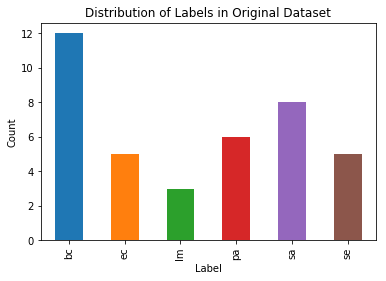

In [10]:
%matplotlib inline

ax = pd.Series(y).value_counts().sort_index().plot(kind='bar')
ax.set(xlabel='Label',
      ylabel='Count',
      title='Distribution of Labels in Original Dataset');

(59, 3129) (59,)


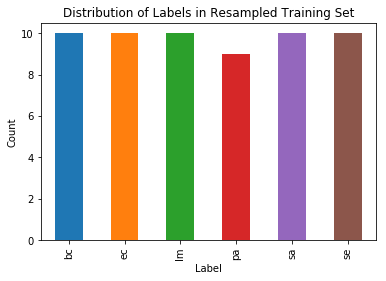

In [11]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import ADASYN

RANDOM_STATE = 42

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=7, random_state=RANDOM_STATE)

adasyn = ADASYN(sampling_strategy='all', random_state=RANDOM_STATE, n_neighbors=1)
X_train, y_train = adasyn.fit_resample(X_train, y_train)

print(X_train.shape, y_train.shape)

ax = pd.Series(y_train).value_counts().sort_index().plot(kind='bar')
ax.set(xlabel='Label',
      ylabel='Count',
      title='Distribution of Labels in Resampled Training Set');

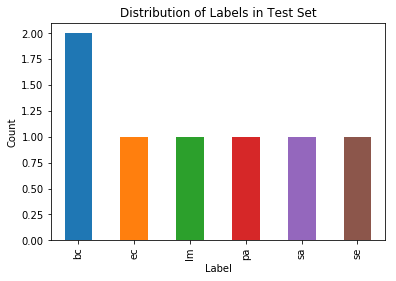

In [12]:
ax = pd.Series(y_test).value_counts().sort_index().plot(kind='bar')
ax.set(xlabel='Label',
      ylabel='Count',
      title='Distribution of Labels in Test Set');

# PCA + SVM

In [13]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.99, svd_solver='full')
pca.fit(X_train)

X_pca = pca.transform(X_train)

print(X_pca.shape)

(59, 3)


In [14]:
from sklearn.svm import SVC
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold, cross_val_score, GridSearchCV

param_grid = {
    'kernel': ['linear', 'rbf'],
    'gamma': [10 ** -n for n in range(10)],
    'C': [10 ** n for n in range(-9, 2)]
}

cv = StratifiedKFold(n_splits=3)
clf = SVC()

grid_search = GridSearchCV(clf, param_grid, cv=cv, verbose=10, n_jobs=4)
grid_search.fit(X_pca, y_train)

print(grid_search.best_score_)
print(grid_search.best_params_)

Fitting 3 folds for each of 220 candidates, totalling 660 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Batch computation too fast (0.1877s.) Setting batch_size=2.
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Batch computation too fast (0.0236s.) Setting batch_size=32.
[Parallel(n_jobs=4)]: Done  27 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 164 tasks      | elapsed:    1.6s


0.8135593220338984
{'C': 10, 'gamma': 1, 'kernel': 'rbf'}


[Parallel(n_jobs=4)]: Done 452 tasks      | elapsed:    1.9s
[Parallel(n_jobs=4)]: Done 660 out of 660 | elapsed:    2.0s finished
/home/anthony/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [15]:
%%time

cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=20)
scores = cross_val_score(grid_search.best_estimator_, X_pca, y_train, cv=cv)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.83 (+/- 0.17)
CPU times: user 186 ms, sys: 154 µs, total: 186 ms
Wall time: 185 ms


In [16]:
%%time

cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=20)
scores = cross_val_score(grid_search.best_estimator_, X_train, y_train, cv=cv)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.87 (+/- 0.15)
CPU times: user 808 ms, sys: 11.9 ms, total: 820 ms
Wall time: 817 ms


# Random Forest with Decision Stumps

In [17]:
%%time

from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=1024, max_depth=1, random_state=RANDOM_STATE)
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=20)
scores = cross_val_score(clf, X_pca, y_train, cv=cv)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.62 (+/- 0.18)
CPU times: user 1min 46s, sys: 50.7 ms, total: 1min 46s
Wall time: 1min 46s


In [18]:
%%time

clf = RandomForestClassifier(n_estimators=1024, max_depth=1, random_state=RANDOM_STATE)
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=20)
scores = cross_val_score(clf, X_train, y_train, cv=cv)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.80 (+/- 0.15)
CPU times: user 1min 55s, sys: 84 ms, total: 1min 55s
Wall time: 1min 55s


# AdaBoost

In [19]:
%%time

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),
                        n_estimators=1024)
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=20)
scores = cross_val_score(clf, X_pca, y_train, cv=cv)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.50 (+/- 0.23)
CPU times: user 2min 11s, sys: 88 ms, total: 2min 11s
Wall time: 2min 11s


In [20]:
%%time

clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),
                        n_estimators=1024)
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=20)
scores = cross_val_score(clf, X_train, y_train, cv=cv)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.70 (+/- 0.20)
CPU times: user 12min 58s, sys: 320 ms, total: 12min 58s
Wall time: 12min 59s


# Validation

              precision    recall  f1-score   support

          bc       0.86      1.00      0.92        12
          ec       0.80      0.80      0.80         5
          lm       0.67      0.67      0.67         3
          pa       0.71      0.83      0.77         6
          sa       1.00      0.75      0.86         8
          se       1.00      0.80      0.89         5

   micro avg       0.85      0.85      0.85        39
   macro avg       0.84      0.81      0.82        39
weighted avg       0.86      0.85      0.85        39



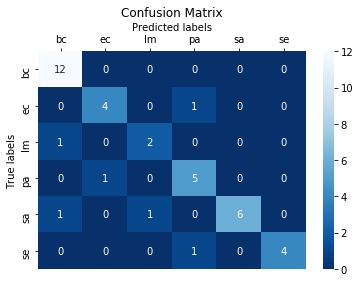

In [21]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

y_pred = grid_search.best_estimator_.predict(pca.transform(X))

print(classification_report(y, y_pred))

labels = df_concat.index.levels[0]
cm = confusion_matrix(y, y_pred, labels)    

ax = sns.heatmap(cm, annot=True, cmap='Blues_r')
ax.set(xlabel='Predicted labels', 
       ylabel='True labels',
       title='Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top') 
ax.yaxis.set_ticklabels(labels);

/home/anthony/miniconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/anthony/miniconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/anthony/miniconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

          bc       0.50      1.00      0.67         2
          ec       0.00      0.00      0.00         1
          lm       0.00      0.00      0.00         1
          pa       0.00      0.00      0.00         1
          sa       0.00      0.00      0.00         1
          se       0.00      0.00      0.00         1

   micro avg       0.29      0.29      0.29         7
   macro avg       0.08      0.17      0.11         7
weighted avg       0.14      0.29      0.19         7



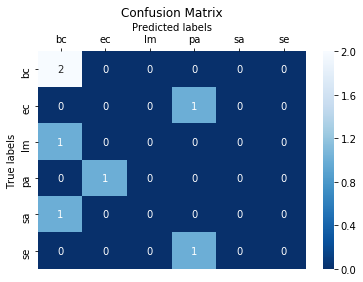

In [22]:
y_pred = grid_search.best_estimator_.predict(pca.transform(X_test))

print(classification_report(y_test, y_pred))

labels = df_concat.index.levels[0]
cm = confusion_matrix(y_test, y_pred, labels)    

ax = sns.heatmap(cm, annot=True, cmap='Blues_r')
ax.set(xlabel='Predicted labels', 
       ylabel='True labels',
       title='Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top') 
ax.yaxis.set_ticklabels(labels);